# **What do Quora users talk about?**

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/Quora_icon.svg/2048px-Quora_icon.svg.png" width="800" height="800" align="center"/>

Image source: https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/Quora_icon.svg/2048px-Quora_icon.svg.png

## **Installing libraries for NLP**

In [ ]:
# LDA visualization tool
!pip install -U pyldavis

# Download en_core_web_sm for spacy
!python -m spacy download en_core_web_sm

In [3]:
# Standard imports
import numpy  as np
import pandas as pd

import itertools
import random
import math  
import copy

from collections import Counter

from pprint import pprint  # nicer printing

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Other NLP
import re
import spacy
import nltk
from nltk.corpus import stopwords

# General Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
%matplotlib inline  
import seaborn as sns
sns.set(style= 'white')

# Special Plotting
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

# ignore some warnings 
import warnings
warnings.filterwarnings('ignore')

import textwrap

from ast import literal_eval

from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

# Set the maximum number of rows displayed by pandas
pd.options.display.max_rows = 1000

# Set some CONSTANTS that will be used later
SEED    = 41  # base to generate a random number
SCORE   = 'roc_auc'
FIGSIZE = (16, 10)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Loading the dataset**

In [7]:
# Loading the data
quora = pd.read_csv('./gdrive/MyDrive/test.csv.zip')
quora.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [9]:
# Examine dataframe shape
shape = quora.shape
print('\nTweets DataFrame Shape :', shape)
print('\nNumber of rows :', shape[0])
print('\nNumber of columns :', shape[1])


Tweets DataFrame Shape : (375806, 2)

Number of rows : 375806

Number of columns : 2


# **Text Pre-processing**

In [8]:
# Print 100 random questions texts to visualize them
for i in range(500, 600):
  
  # Retrieve tweet text
  question = quora.iloc[i, 1]

  print('\nTweet number ', i, ':', question)


Tweet number  500 : Why transverse wave did not want to travel through a medium?

Tweet number  501 : How can I regain my long lost reading habit?

Tweet number  502 : A ball is dropped from 1 meters above the ground at the top of the first bounce it is 50 cm above the ground l. How much energy is stored in the ball at the top of the first bounce compared with the energy stored in it just before it dropped?

Tweet number  503 : Who is the most overpowered anime character?

Tweet number  504 : Why are electric blankets bad for kids?

Tweet number  505 : What exactly do people mean when they say taht GST will change the way of doing business for everyone?

Tweet number  506 : When Vinsmoke Sanji use Diable Jambe, why does he spin around like a ballerina?

Tweet number  507 : How can I get a job of an Electrical engineer in the Indian Railways?

Tweet number  508 : How does the aim and objectives of acquisition activities differ between the private and public sector?

Tweet number  509 :

## **Tokenization and stopwords removal**

In [74]:
# Test use of spacy by using the spacy.load() function
Language = spacy.load('en_core_web_sm') # Builds a basic Language tool to perform NLP

# Instantiate tokenizer
tokenizer = spacy.tokenizer.Tokenizer(Language.vocab)

# Custom stopwords to add
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@', ':', '--', 'w/', "'s", "?", "people", "best", "good"] # Add custom stopwords here if you see any!!

# Customize stop words by adding to the default list
STOP_WORDS = Language.Defaults.stop_words.union(custom_stopwords).union(stopwords)
print("Number of stopwords: ", len(STOP_WORDS))

Number of stopwords:  407


In [75]:
# Define custom function to wrap simple_preprocess() from gensim
def preprocess_data(txt):
  word_list = gensim.utils.simple_preprocess(txt, deacc=True)
  preprocessed_txt = ' '.join(i for i in word_list) # Join list of words back into a sentence

  return preprocessed_txt

# Apply to column
quora['gensim_preprocess'] = quora['question_text'].apply(preprocess_data)

# Visualize pre-processing
quora.iloc[:,-2:]

,tokens,lemma
0,"[women, rude, arrogant, little, bit, wealth, p...","[woman, rude, arrogant, little, bit, wealth, p..."
1,"[apply, rv, college, engineering, bms, college...","[apply, rv, college, engineering, bm, college,..."
2,"[nurse, practitioner]","[nurse, practitioner]"
3,[entrepreneurs],[entrepreneur]
4,"[education, making, good, people, nowadays]","[education, make, good, people, nowadays]"
...,...,...
375801,"[countries, listed, gold, import, indua]","[country, list, gold, import, indua]"
375802,"[alternative, dresses, formal, parties]","[alternative, dress, formal, party]"
375803,"[find, best, friendship, quotes, telugu]","[find, best, friendship, quote, telugu]"
375804,"[causes, refraction, light]","[cause, refraction, light]"


In [76]:
# Get tokens from tweets
tokens = []

for doc in tokenizer.pipe(quora['gensim_preprocess'], batch_size=1000):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
quora['tokens'] = tokens

# Visualize tokenization
quora.iloc[:,-3:]

,gensim_preprocess,tokens,lemma
0,why do so many women become so rude and arroga...,"[women, rude, arrogant, little, bit, wealth, p...","[woman, rude, arrogant, little, bit, wealth, p..."
1,when should apply for rv college of engineerin...,"[apply, rv, college, engineering, bms, college...","[apply, rv, college, engineering, bm, college,..."
2,what is it really like to be nurse practitioner,"[nurse, practitioner]","[nurse, practitioner]"
3,who are entrepreneurs,[entrepreneurs],[entrepreneur]
4,is education really making good people nowadays,"[education, making, nowadays]","[education, make, good, people, nowadays]"
...,...,...,...
375801,how many countries listed in gold import in indua,"[countries, listed, gold, import, indua]","[country, list, gold, import, indua]"
375802,is there an alternative to dresses on formal p...,"[alternative, dresses, formal, parties]","[alternative, dress, formal, party]"
375803,where can find best friendship quotes in telugu,"[find, friendship, quotes, telugu]","[find, best, friendship, quote, telugu]"
375804,what are the causes of refraction of light,"[causes, refraction, light]","[cause, refraction, light]"


## **Lemmatization**

In [77]:
# Write a lemmatization function based on nltk.stem.WordNetLemmatizer()
from nltk.stem import WordNetLemmatizer
# Lemmatize with POS Tag
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet') # To use WordNetLemmatizer
nltk.download('punkt')   # To use WordNetLemmatizer

# Function to lemmatize text
def lemmatize_text(txt):

  wordnet_lemmatizer = WordNetLemmatizer() # Define word net lemmatizer to use
  txt = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in txt]

  return txt

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [78]:
# Apply lemmatize_text() to tokenized text 
quora['lemma'] = quora['tokens'].apply(lemmatize_text)

# Visualize tokenization and lemmatization
quora.iloc[:,-4:]

,question_text,gensim_preprocess,tokens,lemma
0,Why do so many women become so rude and arroga...,why do so many women become so rude and arroga...,"[women, rude, arrogant, little, bit, wealth, p...","[woman, rude, arrogant, little, bit, wealth, p..."
1,When should I apply for RV college of engineer...,when should apply for rv college of engineerin...,"[apply, rv, college, engineering, bms, college...","[apply, rv, college, engineering, bm, college,..."
2,What is it really like to be a nurse practitio...,what is it really like to be nurse practitioner,"[nurse, practitioner]","[nurse, practitioner]"
3,Who are entrepreneurs?,who are entrepreneurs,[entrepreneurs],[entrepreneur]
4,Is education really making good people nowadays?,is education really making good people nowadays,"[education, making, nowadays]","[education, make, nowadays]"
...,...,...,...,...
375801,How many countries listed in gold import in in...,how many countries listed in gold import in indua,"[countries, listed, gold, import, indua]","[country, list, gold, import, indua]"
375802,Is there an alternative to dresses on formal p...,is there an alternative to dresses on formal p...,"[alternative, dresses, formal, parties]","[alternative, dress, formal, party]"
375803,Where I can find best friendship quotes in Tel...,where can find best friendship quotes in telugu,"[find, friendship, quotes, telugu]","[find, friendship, quote, telugu]"
375804,What are the causes of refraction of light?,what are the causes of refraction of light,"[causes, refraction, light]","[cause, refraction, light]"


# **Making an LDA topic model for Quora questions**

In [79]:
# Try with first 10'000 questions
sub_quora = quora.head(10000)

In [80]:
# Create Dictionary
id2word = corpora.Dictionary(sub_quora['lemma'])

# Create Corpus
texts = sub_quora['lemma']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [81]:
#Defining a function to loop over number of topics to be used to find an 
#optimal number of tipics
def tune_LDA_topics(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the 
    LDA model with respective number of topics
    """
    coherence_values_topic = []
    model_list_topic = []

    for num_topics in range(start, limit, step):

        print('\nStarting num_topics = ', num_topics)
        
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=num_topics, 
                                                    random_state=47,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)
        
        model_list_topic.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

        print('\nFinishing num_topics = ', num_topics)

    return model_list_topic, coherence_values_topic

In [ ]:
model_list_topic, coherence_values_topic = tune_LDA_topics(dictionary=id2word,
                                                           corpus=corpus,
                                                           texts=sub_quora['lemma'],
                                                           start=2, limit=52, step=3)

Text(0.5, 1.0, 'Tuning the number of topics for LDA tweet topics modelling')

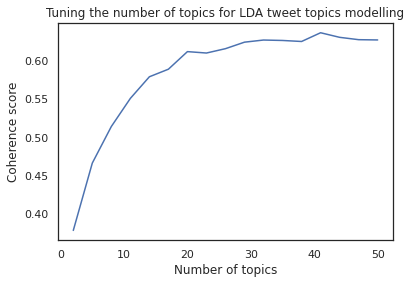

In [30]:
# Print tuning values
tune_df = pd.DataFrame(coherence_values_topic)
tune_df['num_topics'] = [i for i in range(2, 52, 3)]
tune_df

,0,num_topics
0,0.378319,2
1,0.466273,5
2,0.514009,8
3,0.550713,11
4,0.578936,14
5,0.588814,17
6,0.611773,20
7,0.609930,23
8,0.615625,26
9,0.624112,29


In [86]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,          
                            )

data_vectorized = vectorizer.fit_transform(sub_quora['lemma'].apply(' '.join))

lda_model = LatentDirichletAllocation(n_components=29, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
2     -142.648956 -144.836273       1        1  4.732504
0      -38.226749   17.493395       2        1  4.648833
25      57.600552   35.233490       3        1  4.473364
6      107.652412  -59.467628       4        1  4.470432
3       43.978386  -68.189835       5        1  4.266038
4      115.220192   17.179886       6        1  4.250648
14      17.804077  -12.109013       7        1  4.108258
16     135.881744   87.563850       8        1  4.005870
7      -94.396393  -18.700478       9        1  3.878277
24     -62.882755   77.396461      10        1  3.626466
22     -57.167938  175.189194      11        1  3.497672
11     278.703003  -16.236275      12        1  3.473889
17     -33.523014  -53.686317      13        1  3.441866
28      68.760246  132.174850      14        1  3.423461
15    -387.877747 -113.170486      15        1  3.379057
1      -76.785339 -104.047066      16        1  3.306369
27    -185.513367   73.088020      17        1  3.261364
13    -200.727890  189.909454      18        1  3.252760
21      -2.067186 -116.718994      19        1  3.201647
23     -18.255251  127.399948      20        1  3.069592
12     -58.317986 -180.525925      21        1  3.020853
5      169.345932  -27.278856      22        1  2.994304
18      94.968758 -133.541153      23        1  2.984372
9     -119.610428   54.756901      24        1  2.754677
20    -145.092499  -71.032318      25        1  2.696243
8     -175.536407   -7.784925      26        1  2.653415
19      29.444168 -182.010910      27        1  2.448330
10      14.573232   75.647400      28        1  2.376193
26    -218.406631 -194.065659      29        1  2.303247, topic_info=               Term        Freq       Total Category  logprob  loglift
1593          india  247.000000  247.000000  Default  30.0000  30.0000
3193          think  197.000000  197.000000  Default  29.0000  29.0000
3420            way  204.000000  204.000000  Default  28.0000  28.0000
3492           year  202.000000  202.000000  Default  27.0000  27.0000
1768           know  194.000000  194.000000  Default  26.0000  26.0000
3335            use  193.000000  193.000000  Default  25.0000  25.0000
3207           time  181.000000  181.000000  Default  24.0000  24.0000
1834           life  173.000000  173.000000  Default  23.0000  23.0000
721         country  157.000000  157.000000  Default  22.0000  22.0000
370            book  149.000000  149.000000  Default  21.0000  21.0000
3472           work  160.000000  160.000000  Default  20.0000  20.0000
954             don  144.000000  144.000000  Default  19.0000  19.0000
3008          start  147.000000  147.000000  Default  18.0000  18.0000
1212           feel  131.000000  131.000000  Default  17.0000  17.0000
1594         indian  126.000000  126.000000  Default  16.0000  16.0000
3192          thing  122.000000  122.000000  Default  15.0000  15.0000
799             day  127.000000  127.000000  Default  14.0000  14.0000
1717            job  132.000000  132.000000  Default  13.0000  13.0000
2139            new  121.000000  121.000000  Default  12.0000  12.0000
3476          world  129.000000  129.000000  Default  11.0000  11.0000
1299         friend  105.000000  105.000000  Default  10.0000  10.0000
2405       possible  115.000000  115.000000  Default   9.0000   9.0000
1806          learn  120.000000  120.000000  Default   8.0000   8.0000
3316     university  104.000000  104.000000  Default   7.0000   7.0000
2324         person  121.000000  121.000000  Default   6.0000   6.0000
1890           love  107.000000  107.000000  Default   5.0000   5.0000
2120           need  118.000000  118.000000  Default   4.0000   4.0000
1880           look  109.000000  109.000000  Default   3.0000   3.0000
3467          woman  118.000000  118.000000  Default   2.0000   2.0000
887      difference  102.000000  102.000000  Default   1.000